In [3162]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, kurtosis
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from scipy.special import boxcox,inv_boxcox
# import xgboost as xgb
# import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# import os
# print(os.listdir('../kaggle/Housing_Price'))

In [3163]:
df_train = pd.read_csv("~/Housing_Price/train.csv")
df_test = pd.read_csv("~/Housing_Price/test.csv")

In [3164]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [3165]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [3166]:
#check if there any zero in minimal of the price
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [3167]:
#sns.distplot(df_train['SalePrice'], bins=20, rug=True);

In [3168]:
#Skew = ambience distributions data (0=evenly distributed)
#Kurt = to check the outlier data (3=standart value)
print("Skewness: %f" %df_train['SalePrice'].skew())
print("Kurtosis: %f" %df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


In [3169]:
df_train_numeric=df_train.select_dtypes(exclude=['object'])
df_target = df_train.SalePrice


In [3170]:
corr_matrix=df_train_numeric.corr()['SalePrice'].abs().sort_values()
print(corr_matrix)

BsmtFinSF2       0.011378
BsmtHalfBath     0.016844
MiscVal          0.021190
Id               0.021917
LowQualFinSF     0.025606
YrSold           0.028923
3SsnPorch        0.044584
MoSold           0.046432
OverallCond      0.077856
MSSubClass       0.084284
PoolArea         0.092404
ScreenPorch      0.111447
EnclosedPorch    0.128578
KitchenAbvGr     0.135907
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePr

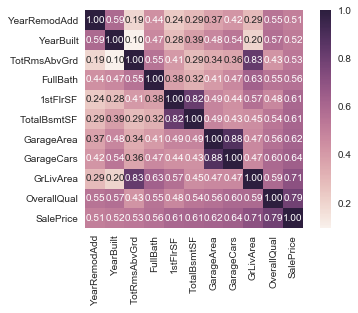

In [3171]:
strong_corrs = corr_matrix[corr_matrix>0.5]
corr_matrix = df_train_numeric[strong_corrs.index].corr()
sns.heatmap(corr_matrix,annot=True, square=True,
           fmt='.2f',)

In [3195]:
#Functions:
def Fill_missing_values(df):
    
    #Since PoolQC has the highest null values according to the data documentation says null values means 'No Pool. 
    #Since majority of houses has no pool. So we will replace those null values with 'None'.
    df["PoolQC"] = df["PoolQC"].fillna("None")

    #MiscFeature : Data documentation says NA means "no misc feature"
    df["MiscFeature"] = df["MiscFeature"].fillna("None")

    #Alley : data description says NA means "no alley access"
    df["Alley"] = df["Alley"].fillna("None")

    #Fence : data description says NA means "no fence"
    df["Fence"] = df["Fence"].fillna("None")

    #FireplaceQu : data description says Null means "no fireplace"
    df['FireplaceQu'] = df['FireplaceQu'].fillna('None')

    #print(df_train.groupby("Neighborhood")["LotFrontage","Neighborhood"].median())
    df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))
    

    # BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : 
    #For all these categorical basement-related features, NaN means that there is no basement.

    # GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 
                'BsmtFinType1', 'BsmtFinType2',
                'GarageType', 'GarageFinish', 'GarageQual', 
                'GarageCond'):
        df[col] = df[col].fillna('None')

    #GarageYrBlt replacing missing data with 0
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
    

    #MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses.
    #We can fill 0 for the area and None for the type
    df["MasVnrType"] = df["MasVnrType"].fillna("None")
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

    #BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : 
    #missing values are likely zero for having no basement
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        df[col] = df[col].fillna(0)

    #BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 :
    #For all these categorical basement-related features, NaN means that there is no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        df[col] = df[col].fillna('None')

    #MSZoning (The general zoning classification) : 'RL' is by far the most common value.
    #So we can fill in missing values with 'RL'
    df['MSZoning'].value_counts()
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])

    #Utilities : Since this is a categorical data and most of the data are of same category, Its not gonna effect on model. 
    #So we choose to drop it
    df['Utilities'].value_counts()
    df = df.drop(['Utilities'], axis=1)

    #Electrical,KitchenQual, Exterior1st, Exterior2nd, SaleType : 
    #Since this all are categorical values so its better to replace nan values with the most used keyword.
    mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
    for col in mode_col:
        df[col] = df[col].fillna(df[col].mode()[0])

    #Functional : data description says NA means typical
    df["Functional"] = df["Functional"].fillna("Typ")

    #MSSubClass : Na most likely means No building class. We can replace missing values with None
    df['MSSubClass'] = df['MSSubClass'].fillna("None")
    
    return df

In [3196]:
def Process_missing_data(df,strtype):
    #Missing data percentage
    cols=df.columns
    if strtype =='train':
        cols=cols.drop(['SalePrice'])
    total = df[cols].isnull().sum().sort_values(ascending=False)
    percent = ((df[cols].isnull().sum()/df[cols].isnull().count())*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
#     f, ax = plt.subplots(figsize=(15,12))
#     plt.xticks(rotation='90')
#     sns.barplot(x=total.index, y=total)
#     plt.xlabel('Features', fontsize=15)
#     plt.ylabel('Percent of missing values',fontsize=15)
#     plt.title('Percent missing data by feature',fontsize=15)
    #plt.show()##uncomment later
    # drop columns/keys that have more than 50% of null values
    #df = df.drop((missing_data[missing_data['Percent'] > 50 ]).index)

    df=Fill_missing_values(df)
    return df




Removing Outliers<br/>
Outlinear in the GrLivArea is recommended by the author of the data to remove it.We can see that there are outlinear with low SalePrice and high GrLivArea. This looks odd. We need to remove it

In [3197]:
def Remove_Outliers(df_notnull,dtype):
    if dtype=='train':
#         fig, ax = plt.subplots()
#         ax.scatter(x = df_notnull['GrLivArea'], y = df_notnull['SalePrice'])
#         plt.ylabel('SalePrice', fontsize=13)
#         plt.xlabel('GrLivArea', fontsize=13)
        # plt.show()##uncomment later
        df_notnull = df_notnull.drop(df_notnull[(df_notnull['GrLivArea']>4000) & (df_notnull['SalePrice']<300000)].index)
    else:
        a=1
    return df_notnull    

In [3198]:
def Create_newfeatures(df_rem_outlier):
    #Year values aren't representative of how old a house is.Instead of the years certain events happened, we want the difference between those years
    ##years_sold = df_rem_outlier['YrSold'] - df_rem_outlier['YearBuilt']

    ##years_since_remod = df_rem_outlier['YrSold'] - df_rem_outlier['YearRemodAdd']

    ## Create new columns
    ##df_rem_outlier['YearsBefSale'] = years_sold
    ##df_rem_outlier['YearsSinceRemod'] = years_since_remod

    ## Drop rows with negative values for both of these new features
    #df_rem_outlier = df_rem_outlier[~(df_rem_outlier['YearsBefSale','YearsSinceRemod'] < 0)]
    #df_rem_outlier = df_rem_outlier.drop([523, 2295, 2549], axis=0)
    ##df_rem_outlier[df_rem_outlier['YearsBefSale'] < 0] = 0
    ##df_rem_outlier[df_rem_outlier['YearsSinceRemod'] < 0] = 0
  
#   df_rem_outlier.drop((df_rem_outlier[(df_rem_outlier.YearsBefSale < 0)
#     df_rem_outlier.drop((df_rem_outlier[(df_rem_outlier.YearsBefSale < 0) | (df_rem_outlier.YearsSinceRemod <0)].index),inplace=True)
    
    ## No longer need original year columns
    ##df_rem_outlier = df_rem_outlier.drop(["YearBuilt", "YearRemodAdd"], axis = 1)

    #Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house
    df_rem_outlier['TotalSF'] = df_rem_outlier['TotalBsmtSF'] + df_rem_outlier['1stFlrSF'] + df_rem_outlier['2ndFlrSF']
    return df_rem_outlier

In [3199]:
def drop_columns(df_new_feats):
    ## Drop columns that leak info about the final sale
    df_new_feats = df_new_feats.drop(["MoSold", "SaleCondition", "SaleType", "YrSold"], axis=1)
    ##Drop columns of low variance ##todo
    return df_new_feats
    

In [3200]:
def plot_target(target):

    sns.distplot(target, fit=norm);
    fig = plt.figure()
    res = stats.probplot(target, plot=plt)


def remove_skew(df_clean,type):
    #skewed features

    numeric_feats = df_clean.dtypes[df_clean.dtypes !='object'].index
    #numeric_feats = df_combined.select_dtypes(exclude=['category'])

    # Check the skew of all numerical features
    skewed_feats = df_clean[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\nSkew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness.head(20)
 
    if type=='train':
        Skewness in target column Saleprice
        skewed_target=skew(df_clean['SalePrice'])
        print('skew in SalePrice')
        #plot_target(df_clean['SalePrice'])
        
    
    skewness = skewness[abs(skewness) > 0.75]
    print("There are {} skewed numerical features to log transform".format(skewness.shape[0]))

#     from scipy.special import log1p
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        #df_train[feat] += 1
        #df_clean[feat] = np.boxcox1p(df_clean[feat], lam)
        df_clean[feat] = np.log1p(df_clean[feat])

    if type=='train':
        #Skewness in target column Saleprice
        #skewed_target=skew(df_clean['SalePrice'])
        print('SalePrice after normalisation')
        plot_target(df_clean['SalePrice'])
    
    return df_clean

In [3201]:
def transform_features(df):
    #dummy encoding all categorical features
    text_cols = df.select_dtypes(include=['object']).columns
    
    dummies=pd.get_dummies(df[text_cols])
    df = pd.concat([df, dummies], axis=1) 
    df=df.drop(text_cols,axis=1)
    #df_clean=pd.getdummies(df_clean,drop_first=True)
    
    return df
    

In [3202]:

def Pre_Process(df,strtype):
    df_notnull=Process_missing_data(df,strtype)
    #print(df_notnull.info())
    df_rem_outlier=Remove_Outliers(df_notnull,strtype)
    #print(df_rem_outlier.info())
    df_new_feats=Create_newfeatures(df_rem_outlier)
    #print(df_new_feats.info())
    #df_clean=drop_columns(df_new_feats)
    #print(df_clean.info())
    df_unskewed=remove_skew(df_new_feats,strtype)
    df_transform=transform_features(df_unskewed)
    
    return df_transform

In [3203]:
def align_testdataset(train_cols,test):
    missing_cols = set(train_cols ) - set( test.columns )
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        test[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    test = test[train_cols]
    return test

In [3204]:
#Save the 'Id' column
train_ID = df_train['Id']
test_id=df_test["Id"]

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

#Preprocess train and test data
df_train=Pre_Process(df_train,'train') 
df_test=Pre_Process(df_test,'test')

#drop target column from train data
train_target=df_train["SalePrice"]
df_train.drop("SalePrice", axis = 1, inplace = True)

#Ensure test and train columns match
df_test=align_testdataset(df_train.columns,df_test)

print(df_train.shape)
print(df_test.shape)





Skew in numerical features: 

There are 38 skewed numerical features to log transform

Skew in numerical features: 

There are 37 skewed numerical features to log transform
(1458, 300)
(1459, 300)


In [3205]:
#Validation function
n_folds = 5

def rmsle_cv(model,df_train,target):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    rmse= np.sqrt(-cross_val_score(model, df_train.values, target, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
    

In [3206]:
def train_test(df_train,df_test,target):
          
#     df_train=df_train.select_dtypes(include=['int64','float64'])
#     df_test=df_test.select_dtypes(include=['int64','float64'])
    df_test=df_test.fillna(0)
    df_train=df_train.fillna(0)
    #lr = linear_model.LinearRegression()
    rmse_values = []
    
#To make our model avoid Overfitting and noisy we will use Regularization
    #Ridge Regression
    KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
    score = rmsle_cv(KRR,df_train,target)
    print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    
    #Lasso regression
    lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
    score = rmsle_cv(lasso,df_train,target)
    print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    
    #ElasticNet Regression
    ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
    score = rmsle_cv(ENet,df_train,target)
    print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    
    Gradient Boosting Regression
    GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=30, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
    score = rmsle_cv(GBoost,df_train,target)
   print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    
#Fit the training dataset on every model
    
    LassoMd = lasso.fit(df_train.values,target)
    ENetMd = ENet.fit(df_train.values,target)
    KRRMd = KRR.fit(df_train.values,target)
    GBoostMd = GBoost.fit(df_train.values,target)

    #final_predictions=(np.expm1(LassoMd.predict(df_test.values)) + np.expm1(ENetMd.predict(df_test.values)) + np.expm1(KRRMd.predict(df_test.values)) + np.expm1(GBoostMd.predict(df_test.values)) ) / 4
    final_predictions=(np.expm1(LassoMd.predict(df_test.values)) + np.expm1(ENetMd.predict(df_test.values)) + np.expm1(KRRMd.predict(df_test.values))) / 3
    
    print (final_predictions)
    return final_predictions
 
final_predictions=train_test(df_train,df_test,train_target)

Kernel Ridge score: 0.1168 (0.0058)

Lasso score: 0.1116 (0.0069)

ElasticNet score: 0.1116 (0.0069)

[ 119299.51348702  161230.46652694  186953.37234579 ...,  172940.96474051
  118064.65206676  217542.95438503]


In [3207]:
def save_submission_file(final_predictions):

    ss = pd.read_csv('~/Housing_Price/sample_submission.csv')
    ss.loc[:, 'SalePrice'] = final_predictions

    ss.to_csv('~/Housing_Price/Result.csv',
              index=False)

save_submission_file(final_predictions)    